# Import Statements, Preliminaries

In [1]:
%autosave 180

Autosaving every 180 seconds


In [1]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from astropy.utils.data import get_pkg_data_filename
import galsim
import os
import math
import time
import logging
import sys
import fitsio

In [3]:
simname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/mag2/Chinchilla-4-y3wlpz.0.fits"
truthname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/Chinchilla-4_lensed.4.fits"

# Functions and List Creation

In [6]:
file = os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')

span = range(10000)

_RA = fitsio.read(file, columns='RA', rows=span, ext=1)
_DEC = fitsio.read(file, columns='DEC', rows=span, ext=1)
_HLR = fitsio.read(file, columns='SIZE', rows=span, ext=1)
LMAG = fitsio.read(file, columns = 'LMAG', rows=span, ext=1)
EPSILON = fitsio.read(file, columns='EPSILON', rows=span, ext=1)
RBAND = LMAG[:,1]
E1 = EPSILON[:,0]
E2 = EPSILON[:,1]

In [33]:
x, y = np.mgrid[-24.5:25.5:1, -24.5:25.5:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

def HSMfunc(integer):
    _moments, _gfluxes, _images, failures = ([] for i in range(4))
    for i in range(integer):
        rng = galsim.BaseDeviate(215324) # make noise object
        gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005)

        hlradius = _HLR[i] # catalogs  
        elip1 = E1[i]
        elip2 = E2[i]
        magnitude = RBAND[i]
        gflux = 10**((magnitude-22.5)/(-2.5))
        
        _gfluxes.append(gflux) # make galaxy
        gal = galsim.Gaussian(flux=gflux, half_light_radius=hlradius)
        
        gal = gal.shear(galsim.Shear(e1=elip1, e2=elip2)) # shearing
        
        image = galsim.ImageF(50, 50) # create image, convolve
        final = galsim.Convolve([gal])
        image = final.drawImage(image, scale=0.2)
        image.addNoise(gaussiannoise)
        
        image2 = galsim.ImageF(50, 50) # create image...again
        final2 = galsim.Convolve([gal])
        image2 = final2.drawImage(image2, scale=0.2)
        _images.append(image2)

        moment = image.FindAdaptiveMom(strict = False ,guess_sig=hlradius*5) # HSM
        _moments.append(moment)
        if moment.moments_n_iter  == 0:
            failures.append(i)
            
    return _moments, _gfluxes, _images, failures 


def matrixfunc(integer):
    _covariances = []
    _noisematrices = []
    for i in range(integer):
        rng = galsim.BaseDeviate(215324) # make noise object
        gaussiannoise = galsim.GaussianNoise(rng, sigma=0.005) 
        
        hlradius = _HLR[i] # catalogs
        sigma = 1/(np.sqrt(2*np.log(2))) * hlradius 
        elip1 = E1[i]
        elip2 = E2[i]
        magnitude = RBAND[i]
        gflux = 10**((magnitude-22.5)/(-2.5))
        
        noiseimage = galsim.ImageF(50, 50) # make image


        shearing2 = galsim.Shear(e1=-1*elip1, e2=elip2) # The negative sign in e1 is due to the difference in how GalSim treats 
        matrix = (shearing2.getMatrix())*(sigma**2)*25  # shearing matrices
        
        _covariances.append(matrix)
        noiseimage.addNoise(gaussiannoise)
        _noisematrices.append(noiseimage)
        
    return _covariances, _noisematrices

# Function Calls

In [9]:
_moments, _gfluxes, _images, failures  = HSMfunc(2000)
_covariances1, _noisematrices1 = matrixfunc(2000)

moments = [i for j, i in enumerate(_nmoments1) if j not in failures]
gfluxes = [i for j, i in enumerate(_gfluxes1) if j not in failures]
covariances = [i for j, i in enumerate(_covariances1) if j not in failures] # HSM doesn't always converge well, so the purpose of this is to remove galaxies for which HSM didn't converge.
images = [i for j, i in enumerate(_images) if j not in failures]
noisematrices = [i for j, i in enumerate(_noisematrices) if j not in failures]
HLR = [i for j, i in enumerate(_HLR) if j not in failures]

matrixfluxes = np.zeros(len(moments))
hsmfluxes = np.zeros(len(moments))

for j in range(len(moments)):
    rv = multivariate_normal([0, 0], covariances[j])
    r1 = np.sum(np.multiply(rv.pdf(pos), images[j].array + noisematrices[j].array))
    r2 = np.sum(np.multiply(rv.pdf(pos), rv.pdf(pos)))
    matrixfluxes[j] = r1/r2
    
for i in range(len(moments)):
    hsmfluxes[i] = moments[i].moments_amp

In [10]:
# from scipy import integrate
# rv = multivariate_normal([0, 0], covariances[j])
# f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3,figsize=(15,15))
# im1 = ax1.imshow(rv.pdf(pos)*gfluxes[0])
# im2 = ax2.imshow(images[0].array)
# im3 = ax3.imshow(images[0].array-rv.pdf(pos)*gfluxes[0])
# f.colorbar(im1,ax=ax1)
# f.colorbar(im2,ax=ax2)
# f.colorbar(im3,ax=ax3)

# grid = np.array([[integrate.dblquad(lambda b, a : rv.pdf([a,b]), x, x+1, lambda a: y, lambda a: y+1)[0] for y in range(-25, 25)] for x in range(-25, 25)])

# print(grid.shape)
# im4 = ax4.imshow(grid*gfluxes[0])
# im5 = ax5.imshow(images[0].array)
# im6 = ax6.imshow(images[0].array-grid*gfluxes[0])
# f.colorbar(im4,ax=ax4)
# f.colorbar(im5,ax=ax5)
# f.colorbar(im6,ax=ax6)

# im7 = ax7.imshow(rv.pdf(pos)*gfluxes[0])
# im8 = ax8.imshow(grid*gfluxes[0])
# im9 = ax9.imshow(rv.pdf(pos)*gfluxes[0]-grid*gfluxes[0])
# f.colorbar(im7,ax=ax7)
# f.colorbar(im8,ax=ax8)
# f.colorbar(im9,ax=ax9)

# f.tight_layout()
# print(np.sum(images[0].array), gfluxes[0])

# Plot of Matrix Flux vs. HSM Flux

intercept: -0.005120356153456074
slope: [1.04481908]


Text(0, 0.5, 'HSM Flux')

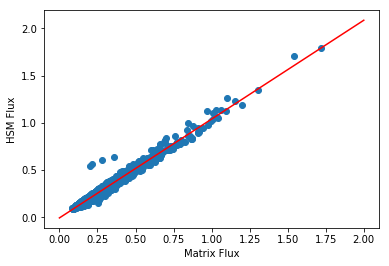

In [22]:
npmatrixfluxes = matrixfluxes.reshape((-1, 1))
model = LinearRegression().fit(npmatrixfluxes, hsmfluxes)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


plt.figure()
z = np.linspace(0, 2, 100)
y = z*model.coef_ + model.intercept_
plt.plot(z, y, '-r')

plt.scatter(matrixfluxes, hsmfluxes)
plt.xlabel("Matrix Flux")
plt.ylabel("HSM Flux")

# Plot of Matrix Flux vs. Galaxy Flux

intercept: -0.01461389552257647
slope: [1.04348631]


Text(0, 0.5, 'Galaxy Flux')

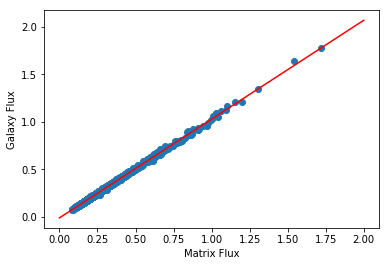

In [23]:
npmatrixfluxes = matrixfluxes.reshape((-1, 1)) # best fit line 
model = LinearRegression().fit(npmatrixfluxes, gfluxes)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


plt.figure()
z = np.linspace(0, 2, 100)
y = z*model.coef_ + model.intercept_
plt.plot(z, y, '-r')

plt.scatter(matrixfluxes, gfluxes)
plt.xlabel("Matrix Flux")
plt.ylabel("Galaxy Flux")

# Plot of HSM Flux vs. Galaxy Flux

intercept: -0.004468495327790589
slope: [0.98026107]


Text(0, 0.5, 'HSM Flux')

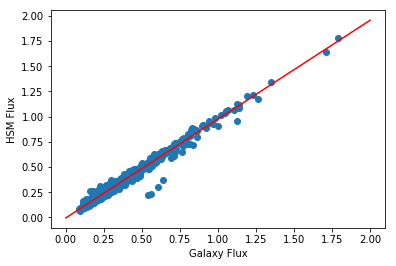

In [28]:
nphsmfluxes = hsmfluxes.reshape((-1, 1)) # best fit line 
model = LinearRegression().fit(nphsmfluxes, gfluxes)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


plt.figure()
z = np.linspace(0, 2, 100)
y = z*model.coef_ + model.intercept_
plt.plot(z, y, '-r')

plt.scatter(nphsmfluxes, gfluxes)
plt.xlabel("Galaxy Flux")
plt.ylabel("HSM Flux")

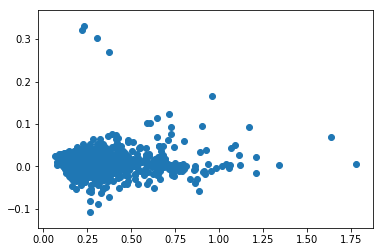

In [14]:
plt.scatter(gfluxes, hsmfluxes - gfluxes)

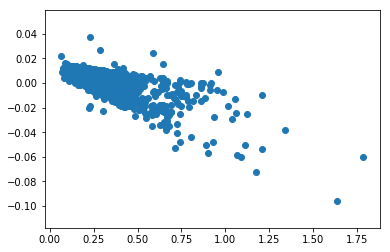

In [15]:
plt.scatter(gfluxes, [matrixfluxes[i]-gfluxes[i] for i in range(len(matrixfluxes))])

# Delta Flux Function Calls

In [37]:
_dmoments, _dgfluxes, _dimages, dfailures  = HSMfunc(2000)
_dcovariances, _dnoisematrices = matrixfunc(2000)

dmoments = [i for j, i in enumerate(_dmoments) if j not in dfailures]
dgfluxes = [i for j, i in enumerate(_dgfluxes) if j not in dfailures]
dcovariances = [i for j, i in enumerate(_dcovariances) if j not in dfailures]
dimages = [i for j, i in enumerate(_dimages) if j not in dfailures]
dnoisematrices = [i for j, i in enumerate(_dnoisematrices) if j not in dfailures]

dmatrixfluxes = np.zeros(len(dmoments))
dhsmfluxes = np.zeros(len(dmoments))

for j in range(len(dmoments)):
    rv = multivariate_normal([0, 0], dcovariances[j])
    r1 = np.sum(np.multiply(rv.pdf(pos), dnoisematrices[j].array))
    r2 = np.sum(np.multiply(rv.pdf(pos), rv.pdf(pos))) 
    dmatrixfluxes[j] = r1/r2
    
for i in range(len(dmoments)):
    dhsmfluxes[i] = dmoments[i].moments_amp - dgfluxes[i]

In [17]:
# plt.figure()
# plt.scatter(matrixfluxes, gfluxes)
# plt.xlabel("matrix fluxes")
# plt.ylabel("galaxy fluxes")

Text(0, 0.5, 'HSM Flux')

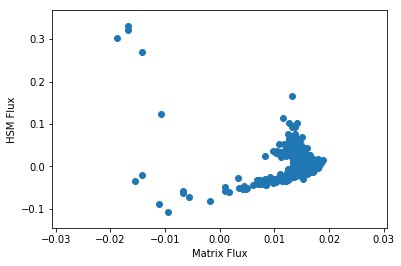

In [39]:
plt.figure()
plt.scatter(dmatrixfluxes, dhsmfluxes)
#plt.ylim([-0.03, 0.03])
#plt.xlim([-0.03, 0.03])
plt.xlabel("Matrix Flux")
plt.ylabel("HSM Flux")

In [2]:
def getShearMat(e1, e2):
	'''returns the shear matrix for the given e1, e2, inspired by GalSim'''
	absesq = e1**2 + e2**2
	if absesq > 1.e-4:
		e2g = 1. / (1. + np.sqrt(1.-absesq))
	else:
		e2g = 0.5 + absesq*(0.125 + absesq*(0.0625 + absesq*0.0390625))
	g1 = e1 * e2g
	g2 = e2 * e2g
	return np.array([ [ 1 + g1 , g2 ], [ g2 , 1 - g1 ] ])

def getPsfMat(sigma):
	'''Returns a PSF correlation matrix for a given sigma'''
	return np.array([ [ sigma**2 , 0 ], [ 0 , sigma**2 ] ])

def getGridSize(hlr, psfSig=0.7):
	'''Returns the side length of the postage stamp we are using to model the galaxy. Approximately 
	3 sigma in each direction, where 'sigma' is a combined measure of the galaxy and psf sigmas'''
	galSig = hlr / 1.1774100225154747
	return int(6 * np.sqrt(galSig**2 + psfSig**2) / 0.2)
	
def getWeights(e1, e2, hlr, psfSig=0.7):
	'''
	Gets a weighting scheme that assumes a gaussian profile for a galaxy with given e1, e2, and hlr. 
	Also returns the side length
	'''
	galSig = hlr / 1.1774100225154747 # Divide by sqrt(ln(2)) to convert from hlr to sigma
	cov = (getShearMat(e1, e2) * galSig**2 + getPsfMat(psfSig)) / 0.2**2

	gridSize = getGridSize(hlr, psfSig)
	x, y = np.mgrid[-1*(gridSize - 1)/2:(gridSize + 1)/2:1, -1*(gridSize - 1)/2:(gridSize + 1)/2:1]
	pos = np.zeros(x.shape + (2,))
	pos[:, :, 0] = x; pos[:, :, 1] = y

	return multivariate_normal.pdf(pos, cov=cov)

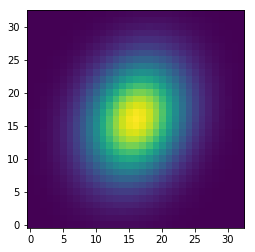

In [6]:
plt.imshow(getWeights(0.5, 0.5, 1), origin='lower')

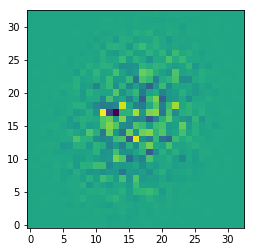

In [9]:
plt.imshow(getWeights(0.5, 0.5, 1)* np.random.normal(0, 0.05, size=(getGridSize(1),getGridSize(1))), origin='lower')